# import necessary library

In [10]:
%matplotlib inline
import numpy as np
import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn
random.seed(2019)

Text(33.0, 0.5, 'y label')

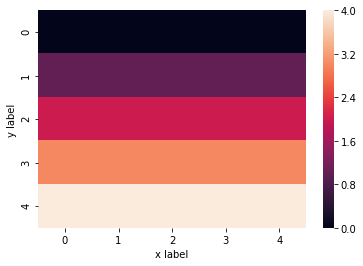

In [11]:
data = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        data[i][j] = i
fig = seaborn.heatmap(data)
fig.set_xlabel("x label")
fig.set_ylabel("y label")

In [107]:
class State:
    def __init__(self, player, dealer, player_own_ace, end_game=False):        
        self.dealer = dealer
        self.player = player
        self.player_own_ace = player_own_ace
        self.end_game = end_game # this is a auxiliary element in state
        
    def __repr__(self):
        return "dealer: %02d, player:%02d, usable ace: %05s, end_game:%s" %\
            (self.dealer, self.player, self.player_own_ace, self.end_game)

    def copy(self):
        return State(self.player, self.dealer, self.player_own_ace, self.end_game)
    
    
    @staticmethod
    def all_states():
        for player in range(12, 22):
            for dealer in range(2, 12):
                for player_own_ace in [True, False]:
                    s = State(player, dealer, player_own_ace)
                    yield s    
    
    @staticmethod
    def random():
        p = random.randint(12, 21)
        d = random.randint(2, 11)
        own_ace = bool(random.randint(0, 1))
        return State(p, d, own_ace)
        
class Action:
    # action = "hit" or "stick"
    action = "hit"
    def __init__(self, action):
        self.action = action

    def __repr__(self):
        return self.action
    
    def isHit(self):
        return self.action == "hit"
    
    def isStick(self):
        return self.action == "stick"
    
    def copy(self):
        return Action(self.action)
            
    @staticmethod
    def all_actions():
        return [Action("hit"), Action("stick")]
    
    @staticmethod
    def random():
        if random.random() < 0.5:
            return Action("hit")
        else:
            return Action("stick")
        
    @staticmethod
    def parse(a_str):
        """
        a_str is a str representation of Action
        """
        return Action(a_str)
    

    
def simulate(s, a):
    """
    s is a instance of State
    a is a instance of Action
    
    simulate the environment, in this case, simulate the actions of dealer, and the card
    return a new state and reward
    """
    reward = 0
    if a.isStick():
        # the player sticks        
        # the turn to dealer to decide to hit or stick, 
        # he sticks on any sum of 17 or greater and hits otherwise
        dealer_own_ace = s.dealer == 11
        
        while(s.dealer < 17):
            # hit
            c = random.randint(2, 11)
            s.dealer += c      
            
        if s.dealer > 21 and dealer_own_ace:
            s.dealer -= 10
        
        while(s.dealer < 17):
            # hit
            c = random.randint(2, 11)
            s.dealer += c        
        
        # stick
        if s.dealer > 21: # dealer goes bust
            reward = 1
        elif s.dealer < s.player:
            reward = 1
        elif s.dealer > s.player:
            reward = -1
        else:
            reward = 0
        s.end_game = True
    elif a.isHit():
        # the players hits
        c = random.randint(2, 11)
        s.player += c
        
        if s.player > 21:
            if s.player_own_ace:
                # make usable ace to non-usable ace
                s.player = s.player - 10
                s.player_own_ace = False
                
                if s.player > 21:
                    reward = -1
                    s.end_game = True
                    
            else:
                reward = -1
                s.end_game = True
    else:
        raise Exception('HiThere')
        
    return s, reward

# evalution of policy
* hit if sum < 20, otherwise stick

In [110]:
def stick_20_21(s):
    """
    s: an instance of State
    """
    if s.player < 20:
        return Action("hit")
    else:
        return Action("stick")
    
def prediction(times, policy):
    value = {}
    global_res = {}
    for t in range(times):
        s = State.random()
        #print(s)
        seq_s = [State.copy(s)]
        r = 0
        while not s.end_game:
            a = policy(s)
            s, r = simulate(s, a) 
            #print(">>> %s" % s)
            seq_s.append(State.copy(s))
        for s in seq_s:
            k = str(s)
            if k in global_res:
                global_res[k].append(r)
            else:
                global_res[k] = [r]
    for k, v in global_res.items():
        value[k] = sum(v) / len(v)
    return value
def print_value(v):
    for s in State.all_states():
        k = str(s)
        print(s, v.get(k, 0))

In [126]:
def plot_policy(policy):
    """
    policy is a function, input state and output action
    """
    own_ace_data = {True: np.zeros((10, 10)), False: np.zeros((10, 10))}
    for s in State.all_states():                
        k = str(s)
        own_ace_data[s.player_own_ace][s.player-12][s.dealer-2] = int(policy(s).isHit())
    ylabels = list(reversed(range(12, 22)))
    xlables = range(2, 11)
    _, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    axes = axes.flatten()
    titles = ["Usable Ace", "No Usable Ace"]
    states = [own_ace_data[True], own_ace_data[False]]
    for title, state, axis in zip(titles, states, axes):
        fig = seaborn.heatmap(np.flipud(state), cmap="YlGnBu", ax=axis, xticklabels=xlables, yticklabels=ylabels)
        fig.set_title(title)
        fig.set_xlabel("dealer showing")
        fig.set_ylabel("player showing")

In [103]:
def plot_value(v):
    own_ace_data = {True: np.zeros((10, 10)), False: np.zeros((10, 10))}
    for s in State.all_states():                
        k = str(s)
        own_ace_data[s.player_own_ace][s.player-12][s.dealer-2] = v.get(k, 0)
    ylabels = list(reversed(range(12, 22)))
    xlables = range(2, 11)
    _, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    axes = axes.flatten()
    titles = ["Usable Ace", "No Usable Ace"]
    states = [own_ace_data[True], own_ace_data[False]]
    for title, state, axis in zip(titles, states, axes):
        fig = seaborn.heatmap(np.flipud(state), cmap="YlGnBu", ax=axis, xticklabels=xlables, yticklabels=ylabels)
        fig.set_title(title)
        fig.set_xlabel("dealer showing")
        fig.set_ylabel("player showing")

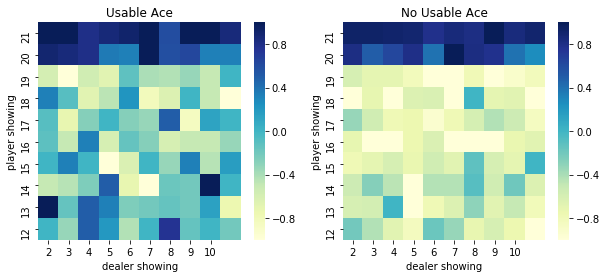

In [50]:
v = prediction(1000, stick_20_21)
plot_value(v)

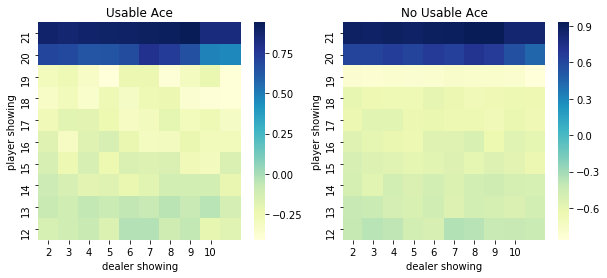

In [51]:
v = prediction(50000, stick_20_21)
plot_value(v)

# find the optimal policy
* Monte Carlo ES (Exploring Starts)

In [90]:
def generate_policy(policy_prob):
    def get_action(s):
        """
        s is an instance of State
        """
        random_number = random.random()
        cumulative_random = 0
        for a, p in policy_prob[str(s)].items():            
            cumulative_random += p
            if random_number < cumulative_random:
                return Action.parse(a)
        raise Exception("no action is found for state: %s" % s)
    return get_action

In [96]:
def monte_carlo_es(times):
    """
    return the optimal policy
    """
    policy_prob = {}    
    q = {}
    global_res = {}   
    # {state -> {action1 -> value, action2 -> value}, state1 -> {...}}
    for s in State.all_states():
        for a in Action.all_actions():
            s_str = str(s)
            a_str = str(a)            
            if s_str not in q:
                q[s_str] = {}
                global_res[s_str] = {}
                policy_prob[s_str] = {}
                
            q[s_str][a_str] = 0.0
            global_res[s_str][a_str] = []
            policy_prob[s_str][a_str] = 1 / len(Action.all_actions())    
    
    
    for t in range(times):
        s0 = State.random()
        a0 = Action.random()
        seq_s = [s0.copy()]
        seq_a = [a0.copy()]        
  
        s1, r = simulate(s0, a0)
        
        while not s1.end_game:
            policy = generate_policy(policy_prob)
            a1 = policy(s0)
            seq_s.append(s1.copy())
            seq_a.append(a1.copy())            
            s1, r = simulate(s1, a1)
            
        for s, a in zip(seq_s, seq_a):
            g_r = global_res[str(s)][str(a)]
            g_r.append(r)
            q[str(s)][str(a)] = sum(g_r) / len(g_r)
            
            same = True
            for i, init_a in enumerate(Action.all_actions()):
                if i == 0:
                    continue
                if q[str(s)][str(init_a)] != q[str(s)][str(Action.all_actions()[i-1])]:
                    same = False
                    break
            
            if not same:
                max_action = Action.all_actions()[0]
                max_q = q[str(s)][str(max_action)]
                for init_a in Action.all_actions()[1:]:
                    if q[str(s)][str(init_a)] > max_q:
                        max_action = init_a
                        max_q = q[str(s)][str(init_a)]
                                        
                for init_a in Action.all_actions():
                    if str(init_a) != str(max_action):
                        policy_prob[str(s)][str(init_a)] = 0
                    else:
                        policy_prob[str(s)][str(init_a)] = 1    
                        
    return generate_policy(policy_prob)

In [131]:
optimal_policy = monte_carlo_es(100)

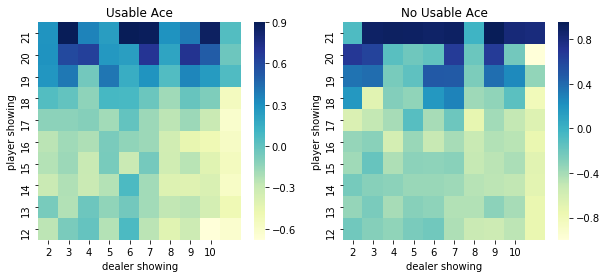

In [132]:
v = prediction(50000, optimal_policy)
plot_value(v)

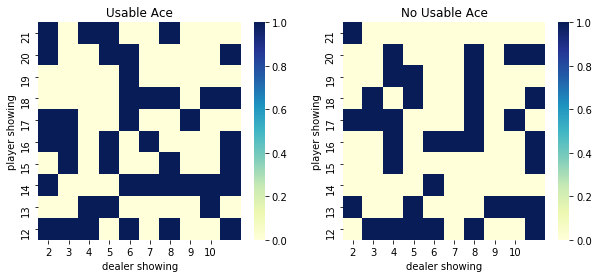

In [133]:
plot_policy(optimal_policy)

In [137]:
optimal_policy = monte_carlo_es(500000)

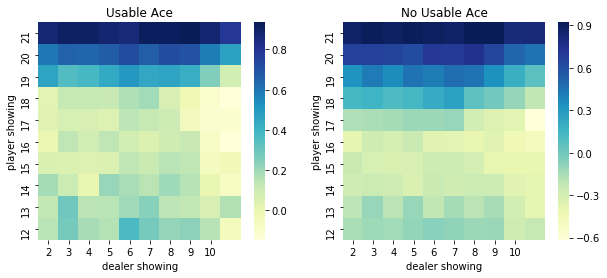

In [138]:
v = prediction(50000, optimal_policy)
plot_value(v)

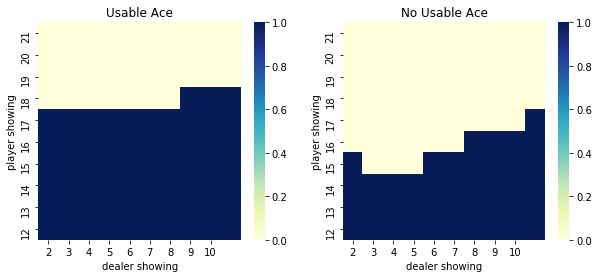

In [139]:
plot_policy(optimal_policy)